# Titanic Passengers Survival Prediction

This is the 2nd part of mywork on the popular Titanic dataset. Check the first notebook here:

Import base Python modules

In [1]:
import pandas as pd
import numpy as np
import random as rnd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import sci-kit Machine Learning models

In [2]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# ** Read in both Test and Train data

I have combined the two datasets to make it easier to implement general changes.
Note that both each of the 2 data is still independent of the other.

In [3]:
train_df = pd.read_csv('train (1).csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

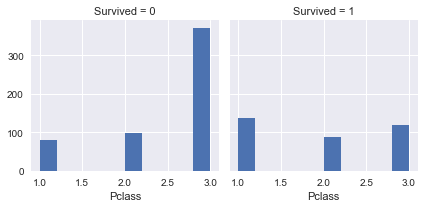

In [4]:
#After doing all analyses, I move on to prediction
graph=sns.FacetGrid(train_df,col='Survived')
graph.map(plt.hist,'Pclass')

# 5. Data Cleaning 

I want to drop both the Cabin and Ticket features.
1. Cabin, becausse it contains so many empty entries
2. Ticket, because it does not bear much info to suggest that it can affect survival

In [7]:
print('At the start, Train:',train_df.shape,'\n\t Test:',test_df.shape)
train_df=train_df.drop(['Cabin','Ticket'],axis=1)
test_df=test_df.drop(['Cabin','Ticket'],axis=1)
print('\nAfter, Train:',train_df.shape,'\n\t Test:',test_df.shape)

At the start, Train: (891, 11) 
	 Test: (418, 10)


ValueError: labels ['Cabin' 'Ticket'] not contained in axis

Extract Passnger Titles.
Passengers' title can affect survival

In [6]:
combine = [train_df, test_df]

for item in combine:
    item['Title']=item.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
    
pd.crosstab(train_df['Title'],train_df['Survived'])


Survived,0,1
Title,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


# Classify similar Titles into Groups

In [46]:
for item in combine:
    item['Title']=item['Title'].replace(['Countess','Don','Sir','Lady','Jonkheer'],'Royal')
    item['Title']=item['Title'].replace(['Capt','Col','Major'],'Military')
    item['Title']=item['Title'].replace(['Rev','Dr'],'Service')
    item['Title']=item['Title'].replace(['Mlle','Ms'],'Miss')
    item['Title']=item['Title'].replace(['Mme'],'Mrs')
    
train_df[['Title','Survived']].groupby('Title',as_index=False).mean().sort_values(by='Survived',ascending=False)

,Title,Survived
4,Mrs,0.793651
2,Miss,0.702703
5,Royal,0.600000
0,Master,0.575000
1,Military,0.400000
6,Service,0.230769
3,Mr,0.156673


In [47]:
for item in combine:
    item['Title']=item['Title'].map({'Royal':1,'Service':2,'Master':3,'Miss':4,'Mr':5,'Mrs':6,'Military':7})
    item['Title']=item['Title'].fillna(0)

train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
418,419,0,2,"Matthews, Mr. William John",male,30.0,0,0,13.0000,S,5
53,54,1,2,"Faunthorpe, Mrs. Lizzie (Elizabeth Anne Wilkin...",female,29.0,1,0,26.0000,S,6
476,477,0,2,"Renouf, Mr. Peter Henry",male,34.0,1,0,21.0000,S,5
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,512.3292,C,4
508,509,0,3,"Olsen, Mr. Henry Margido",male,28.0,0,0,22.5250,S,5


# More Cleaning
*No need for name and passengerID again
**The next task is to convert Categorical data to Ordinal data-type

In [48]:

train_df=train_df.drop(['Name','PassengerId'],axis=1)
test_df=test_df.drop(['Name'],axis=1)

combine=[train_df,test_df]

In [49]:

for item in combine:
    item['Sex']=item['Sex'].map({'male':0,'female':1})
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,5
1,1,1,1,38.0,1,0,71.2833,C,6
2,1,3,1,26.0,0,0,7.9250,S,4
3,1,1,1,35.0,1,0,53.1000,S,6
4,0,3,0,35.0,0,0,8.0500,S,5


In [50]:
print(pd.isnull(train_df).sum())
print('-'*40)
print(pd.isnull(test_df).sum())

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Title         0
dtype: int64
----------------------------------------
PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
Title           0
dtype: int64


# Now we need to compute missing values in the age feature


In [51]:
train_df['Age']=train_df['Age'].fillna(int(np.mean(train_df['Age'])))
test_df['Age']=test_df['Age'].fillna(int(np.mean(test_df['Age'])))
train_df['Age']=train_df['Age'].astype(int)
test_df['Age']=test_df['Age'].astype(int)
combine=[train_df,test_df]

Create five age-bands

In [52]:
train_df['Age Group']=pd.cut(train_df['Age'],5)
train_df[['Age Group','Survived']].groupby('Age Group',as_index=False).mean().sort_values(by='Survived',ascending=False)

,Age Group,Survived
0,"(-0.08, 16.0]",0.550000
3,"(48.0, 64.0]",0.434783
2,"(32.0, 48.0]",0.403226
1,"(16.0, 32.0]",0.344762
4,"(64.0, 80.0]",0.090909


Give ordinal values to age according to age groups

In [53]:
for item in combine:
    item.loc[item['Age']<=16,'Age']=0
    item.loc[(item['Age']>16) & (item['Age']<=32),'Age']=1
    item.loc[(item['Age']>32) & (item['Age']<=48),'Age']=2
    item.loc[(item['Age']>48) & (item['Age']<=64),'Age']=3
    item.loc[item['Age']>64 ,'Age']=4
    
train_df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age Group
305,1,1,0,0,1,2,151.5500,S,3,"(-0.08, 16.0]"
19,1,3,1,1,0,0,7.2250,C,6,"(16.0, 32.0]"
403,0,3,0,1,1,0,15.8500,S,5,"(16.0, 32.0]"
547,1,2,0,1,0,0,13.8625,C,5,"(16.0, 32.0]"
191,0,2,0,1,0,0,13.0000,S,5,"(16.0, 32.0]"


In [54]:
train_df=train_df.drop(['Age Group'],axis=1)
combine=[train_df,test_df]
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,2,0,0,7.8292,Q,5.0
1,893,3,1,2,1,0,7.0000,S,6.0
2,894,2,0,3,0,0,9.6875,Q,5.0
3,895,3,0,1,0,0,8.6625,S,5.0
4,896,3,1,1,1,1,12.2875,S,6.0


Combine both the 'Parch' and 'SibSp' Features to check passengers that came with family members and those that were alone 

In [55]:
for item in combine:
    item['nFamily']=item['Parch']+item['SibSp']+1
    
train_df[['nFamily','Survived']].groupby('nFamily',as_index=False).mean().sort_values(by='Survived',ascending=False)

,nFamily,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


#Turn family size to categorical/ordinal type using 'Alone':
    Alone=1
    With family=0

In [56]:
for item in combine:
    item['Alone']=0
    item.loc[item['nFamily']==1,'Alone']=1
    
train_df[['Alone','Survived']].groupby('Alone',as_index=False).mean()

,Alone,Survived
0,0,0.505650
1,1,0.303538


In [57]:
train_df.drop(['Parch','SibSp','nFamily'],axis=1,inplace=True)
test_df.drop(['Parch','SibSp','nFamily'],axis=1,inplace=True)

combine=[train_df,test_df]
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone
0,0,3,0,1,7.2500,S,5,0
1,1,1,1,2,71.2833,C,6,0
2,1,3,1,1,7.9250,S,4,1
3,1,1,1,2,53.1000,S,6,0
4,0,3,0,2,8.0500,S,5,1


#Fill missing data in point of embarkation

In [58]:
train_df['Embarked'].mode()

0    S
dtype: object

In [59]:
for item in combine:
    item['Embarked']=item['Embarked'].fillna('S')
    
train_df[['Embarked','Survived']].groupby('Embarked',as_index=False).mean().sort_values(by='Survived',ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


# Turn Embarked to ordinal data
C: Cherbough=0
    Q: Queenstown=1
    S: Southampton=2

In [60]:
for item in combine:
    item['Embarked']=item['Embarked'].map({'C':0,'Q':1,'S':2}).astype(int)
    item['Age Class']=item['Age']*item['Pclass']
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone,Age Class
0,0,3,0,1,7.2500,2,5,0,3
1,1,1,1,2,71.2833,0,6,0,2
2,1,3,1,1,7.9250,2,4,1,3
3,1,1,1,2,53.1000,2,6,0,2
4,0,3,0,2,8.0500,2,5,1,6


In [61]:
#Fill the single missing Fare entry in the test data
test_df['Fare'].fillna(test_df['Fare'].mode(),inplace=True)
combine=[train_df,test_df]
test_df['Fare'].head()

0     7.8292
1     7.0000
2     9.6875
3     8.6625
4    12.2875
Name: Fare, dtype: float64

Create a Fare-Range column and draw insight

In [62]:
train_df['Fare Range']=pd.qcut(train_df['Fare'],4)
train_df[['Fare Range','Survived']].groupby('Fare Range',as_index=False).mean()#.sort_values(by='Survived',ascending=False)

,Fare Range,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [63]:
train_df.drop(['Fare Range'],axis=1,inplace=True)
for item in combine:
    item.drop(['Fare'],axis=1,inplace=True)

# Model, Predict and provide Solution

This is a Classification and Regression plus Supervised Learning problem
1. Logistic Regression
2. KNN or k-Nearest Neighbors
3. Support Vector Machines
4. Naive Bayes classifier
5. Decision Tree
6. Random Forrest
7. Perceptron
8. Artificial neural network
9. RVM or Relevance Vector Machine

In [64]:
#Preparation
X_train=train_df.drop(['Survived'],axis=1)
Y_train=train_df['Survived']
X_test=test_df.drop('PassengerId',axis=1).copy()
X_train.shape,Y_train.shape,X_test.shape

((891, 7), (891,), (418, 7))

In [65]:
X_train.head()

,Pclass,Sex,Age,Embarked,Title,Alone,Age Class
0,3,0,1,2,5,0,3
1,1,1,2,0,6,0,2
2,3,1,1,2,4,1,3
3,1,1,2,2,6,0,2
4,3,0,2,2,5,1,6


# Logistic Regression

In [66]:
log_reg=LogisticRegression()
log_reg.fit(X_train,Y_train)
prediction=log_reg.predict(X_test)
acc_log=round(log_reg.score(X_train,Y_train)*100,3)
print(acc_log)

79.237


# Illustrating correlation of independent fetaure(s) with the dependent feature

In [67]:
coef_test_df=pd.DataFrame(train_df.columns.delete(0))
coef_test_df.columns = ['Feature']
coef_test_df["Correlation"] = pd.Series(log_reg.coef_[0])

coef_test_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.526010
5,Alone,0.045604
4,Title,-0.012998
2,Age,-0.063848
6,Age Class,-0.203992
3,Embarked,-0.218371
0,Pclass,-0.802537


# Support Vector Machines

In [68]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100,4)
print(acc_svc)

82.9405


# K Nearest Neighbour

In [69]:
KNN=KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train,Y_train)
Y_pred=KNN.predict(X_test)
acc_KNN=round(KNN.score(X_train,Y_train)*100,5)
print(acc_KNN)

83.38945


# Gaussian Naive Bayes

In [70]:
GNB=GaussianNB()
GNB.fit(X_train,Y_train)
Y_pred=GNB.predict(X_test)
acc_gnb=round(GNB.score(X_train,Y_train)*100,4)
print(acc_gnb)

77.4411


In [71]:
#Perceptron
perceptron=Perceptron()
perceptron.fit(X_train,Y_train)
Y_pred=perceptron.predict(X_test)
acc_perceptron=round(perceptron.score(X_train,Y_train)*100,4)
print(acc_perceptron)

74.7475


In [72]:
#Linear SVC
l_SVC=LinearSVC()
l_SVC.fit(X_train,Y_train)
Y_pred=l_SVC.predict(X_test)
acc_lsvc=round(l_SVC.score(X_train,Y_train)*100,4)
print(acc_lsvc)

78.7879


In [73]:
#Stochastic Gradient Descent
sgd=SGDClassifier()
sgd.fit(X_train,Y_train)
Y_pred=sgd.predict(X_test)
acc_sgd=round(sgd.score(X_train,Y_train)*100,4)
print(acc_sgd)

76.8799


In [74]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 5)
print(acc_decision_tree)

84.17508


In [75]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 5)
print(acc_random_forest)

84.17508


# Comparing Models

In [1]:
models_df=pd.DataFrame({'Model':['Random Forest','Decision Tree','Stochastic Gradient Descent','Perceptron',
                                 'Logistic Regression','LinearSVC','Gaussian Naive Bayes','K Nearest Neighbour',
                                'Support Vector Machines'],
                       'Score':[acc_random_forest,acc_decision_tree,acc_sgd,acc_perceptron,acc_log,acc_lsvc,acc_gnb,
                               acc_KNN,acc_svc]})
models_df.sort_values(by='Score',ascending=False)

NameError: name 'pd' is not defined

# Preparing Submission

In [77]:
test_df.head(2)

,PassengerId,Pclass,Sex,Age,Embarked,Title,Alone,Age Class
0,892,3,0,2,1,5.0,1,6
1,893,3,1,2,2,6.0,0,6


In [83]:
predictions=pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':Y_pred})
predictions.tail(10)

,PassengerId,Survived
408,1300,1
409,1301,0
410,1302,1
411,1303,1
412,1304,0
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


In [84]:
predictions.to_csv('titanic_submission.csv',index=False)

This submission had a score of 0.7201 on Kaggle. I think it is a good score for a beginner

# Thank You!
